## Grafo non connesso

Cluster assignments:
{0: {0, 1, 2, 3, 4, 5, 6, 8}, 1: {9, 7}}
Dimensione del multi-cut minimo: 2
Tempo di esecuzione: 0.0015134811401367188 secondi


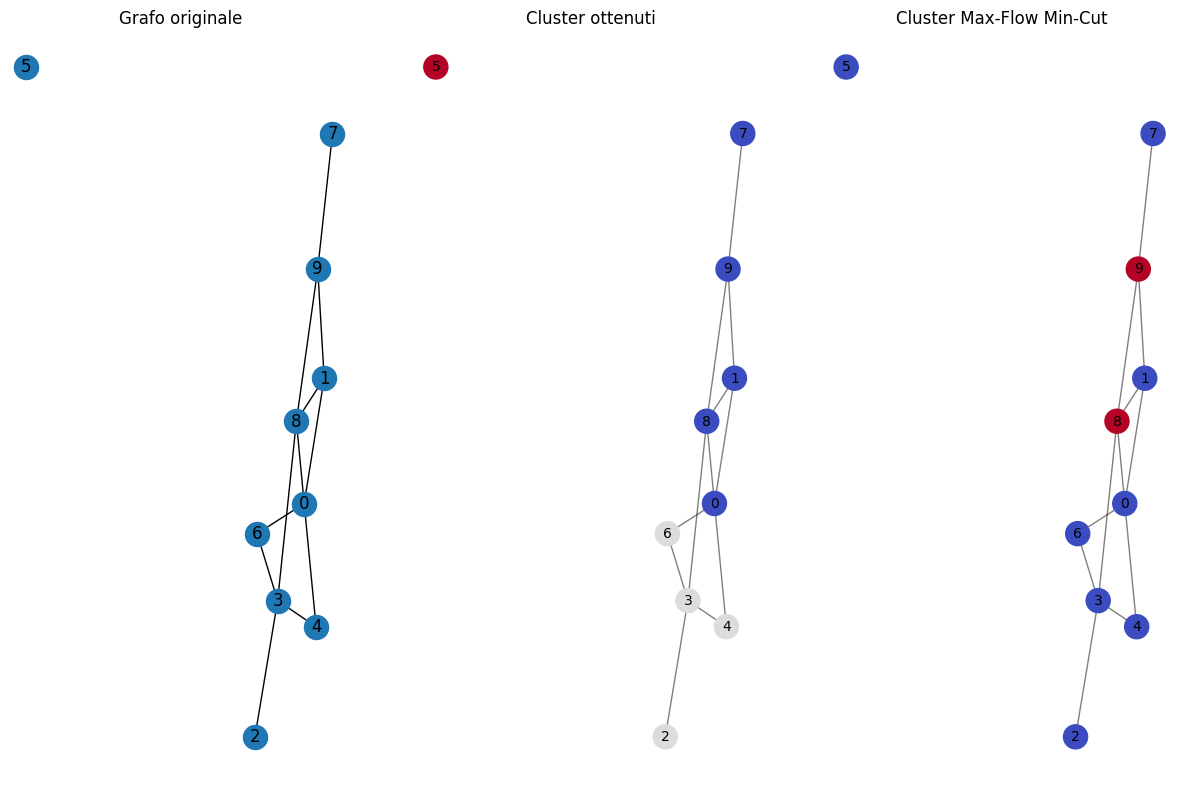

In [55]:
import networkx as nx
import matplotlib.pyplot as plt
import community
import time

# Registra l'istante di inizio dell'esecuzione
start_time = time.time()

# Creazione di un grafo casuale con 10 nodi e 15 archi
G = nx.gnm_random_graph(n=10, m=12, seed=42)  # Aggiungi 'seed' per riproducibilità

# Assegna pesi finiti agli archi del grafo casuale
for u, v in G.edges():
    G.edges[u, v]['capacity'] = 1  # Imposta la capacità a 1 (puoi modificare questo valore a tuo piacimento)

# Estraiamo le feature dei nodi (esempio: gradi dei nodi)
node_degrees = dict(G.degree())

# Convertiamo i gradi dei nodi in una lista di feature
node_features = [degree for node, degree in node_degrees.items()]

# Calcoliamo la partizione ottimale basata sulla modolarità utilizzando Louvain
partition = community.best_partition(G)

# Aggiungi l'etichetta del cluster come attributo per ogni nodo del grafo
nx.set_node_attributes(G, partition, 'cluster_label')

# Scegli i nodi sorgente e destinazione per l'algoritmo Max-Flow Min-Cut
source_node = 0
target_node = 9

# Troviamo il taglio minimo utilizzando l'algoritmo Max-Flow Min-Cut
cut_value, (set_source, set_target) = nx.minimum_cut(G, source_node, target_node)

# Creiamo un dizionario per rappresentare la partizione ottenuta dal taglio minimo
partition_dict = {0: set_source, 1: set_target}

# Creiamo un dizionario di colori personalizzato per mappare ciascun cluster a un valore numerico
color_map = {node: idx for idx, nodes in partition_dict.items() for node in nodes}

# Stampa dell'output: dizionario dei cluster e dimensione del multi-cut minimo
print("Cluster assignments:")
print(partition_dict)
print("Dimensione del multi-cut minimo:", cut_value)

# Registra l'istante di fine dell'esecuzione
end_time = time.time()

# Calcola il tempo di esecuzione in secondi
execution_time = end_time - start_time

# Stampa il tempo di esecuzione
print("Tempo di esecuzione:", execution_time, "secondi")

# Per visualizzare i cluster
pos = nx.spring_layout(G)  # Layout per posizionare i nodi
plt.figure(figsize=(15, 10))  # Dimensione della figura

# Prima visualizzazione: Grafo originale con etichette dei nodi
plt.subplot(1, 3, 1)
plt.axis("off")
nx.draw_networkx(G, pos, with_labels=True)
plt.title("Grafo originale")

# Seconda visualizzazione: Cluster ottenuti da Louvain
plt.subplot(1, 3, 2)
plt.axis("off")
# Coloriamo i nodi in base all'etichetta del cluster
nx.draw_networkx_nodes(G, pos, node_size=300, cmap=plt.get_cmap("coolwarm"), node_color=list(partition.values()))
nx.draw_networkx_edges(G, pos, alpha=0.5)
# Aggiungi le label dei nodi originali (etichette dei nodi iniziali)
node_labels = {node: str(node) for node in G.nodes()}
nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=10, font_color='black')
plt.title("Cluster ottenuti")

# Terza visualizzazione: Cluster ottenuti da Max-Flow Min-Cut
plt.subplot(1, 3, 3)
plt.axis("off")
# Coloriamo i nodi in base alla partizione ottenuta
nx.draw_networkx_nodes(G, pos, node_size=300, cmap=plt.get_cmap("coolwarm"), node_color=list(color_map.values()))
nx.draw_networkx_edges(G, pos, alpha=0.5)
# Aggiungi le label dei nodi originali (etichette dei nodi iniziali)
node_labels = {node: str(node) for node in G.nodes()}
nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=10, font_color='black')
plt.title("Cluster Max-Flow Min-Cut")

plt.show()


## Grafo connesso


Cluster assignments:
{0: {0, 1, 2, 3, 4, 5, 6, 8}, 1: {9, 7}}
Dimensione del multi-cut minimo: 2
Tempo di esecuzione: 0.3386833667755127 secondi


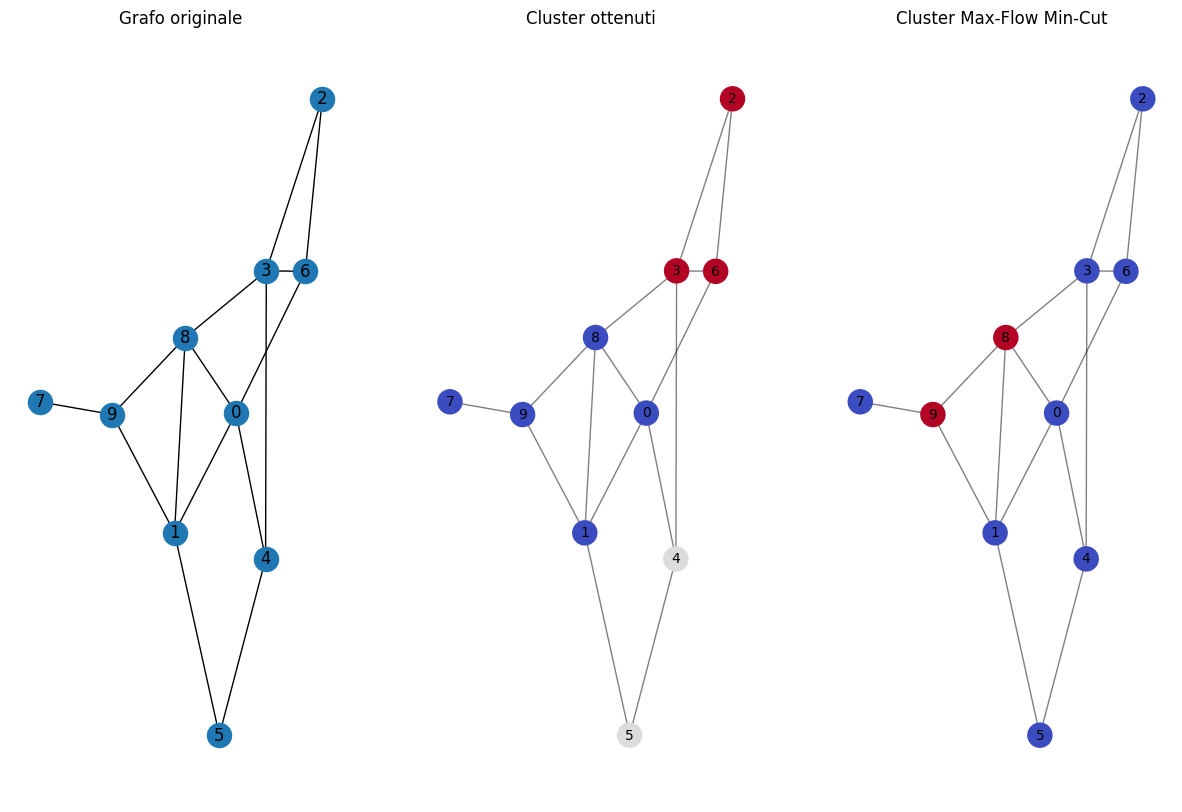

In [56]:
import networkx as nx
import matplotlib.pyplot as plt
import random

# Creazione di un grafo casuale con 10 nodi e 15 archi
G = nx.gnm_random_graph(n=10, m=15, seed=42)

# Verifica se il grafo è connesso
if not nx.is_connected(G):
    # Aggiungi archi casuali fino a quando il grafo diventa connesso
    while not nx.is_connected(G):
        u = random.choice(list(G.nodes()))
        v = random.choice(list(G.nodes()))
        if u != v and not G.has_edge(u, v):
            G.add_edge(u, v)


# Assegna pesi finiti agli archi del grafo casuale
for u, v in G.edges():
    G.edges[u, v]['capacity'] = 1  # Imposta la capacità a 1 (puoi modificare questo valore a tuo piacimento)

# Estraiamo le feature dei nodi (esempio: gradi dei nodi)
node_degrees = dict(G.degree())

# Convertiamo i gradi dei nodi in una lista di feature
node_features = [degree for node, degree in node_degrees.items()]

# Calcoliamo la partizione ottimale basata sulla modolarità utilizzando Louvain
partition = community.best_partition(G)

# Aggiungi l'etichetta del cluster come attributo per ogni nodo del grafo
nx.set_node_attributes(G, partition, 'cluster_label')

# Scegli i nodi sorgente e destinazione per l'algoritmo Max-Flow Min-Cut
source_node = 0
target_node = 9

# Troviamo il taglio minimo utilizzando l'algoritmo Max-Flow Min-Cut
cut_value, (set_source, set_target) = nx.minimum_cut(G, source_node, target_node)

# Creiamo un dizionario per rappresentare la partizione ottenuta dal taglio minimo
partition_dict = {0: set_source, 1: set_target}

# Creiamo un dizionario di colori personalizzato per mappare ciascun cluster a un valore numerico
color_map = {node: idx for idx, nodes in partition_dict.items() for node in nodes}

# Stampa dell'output: dizionario dei cluster e dimensione del multi-cut minimo
print("Cluster assignments:")
print(partition_dict)
print("Dimensione del multi-cut minimo:", cut_value)

# Registra l'istante di fine dell'esecuzione
end_time = time.time()

# Calcola il tempo di esecuzione in secondi
execution_time = end_time - start_time

# Stampa il tempo di esecuzione
print("Tempo di esecuzione:", execution_time, "secondi")

# Per visualizzare i cluster
pos = nx.spring_layout(G)  # Layout per posizionare i nodi
plt.figure(figsize=(15, 10))  # Dimensione della figura

# Prima visualizzazione: Grafo originale con etichette dei nodi
plt.subplot(1, 3, 1)
plt.axis("off")
nx.draw_networkx(G, pos, with_labels=True)
plt.title("Grafo originale")

# Seconda visualizzazione: Cluster ottenuti da Louvain
plt.subplot(1, 3, 2)
plt.axis("off")
# Coloriamo i nodi in base all'etichetta del cluster
nx.draw_networkx_nodes(G, pos, node_size=300, cmap=plt.get_cmap("coolwarm"), node_color=list(partition.values()))
nx.draw_networkx_edges(G, pos, alpha=0.5)
# Aggiungi le label dei nodi originali (etichette dei nodi iniziali)
node_labels = {node: str(node) for node in G.nodes()}
nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=10, font_color='black')
plt.title("Cluster ottenuti")

# Terza visualizzazione: Cluster ottenuti da Max-Flow Min-Cut
plt.subplot(1, 3, 3)
plt.axis("off")
# Coloriamo i nodi in base alla partizione ottenuta
nx.draw_networkx_nodes(G, pos, node_size=300, cmap=plt.get_cmap("coolwarm"), node_color=list(color_map.values()))
nx.draw_networkx_edges(G, pos, alpha=0.5)
# Aggiungi le label dei nodi originali (etichette dei nodi iniziali)
node_labels = {node: str(node) for node in G.nodes()}
nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=10, font_color='black')
plt.title("Cluster Max-Flow Min-Cut")

plt.show()

            

### Problema di ottimizzazione 
#### PLI

Status: Optimal
Archi del multi-cut:
(0, 8)
(1, 5)
(2, 6)
(3, 4)
(7, 9)


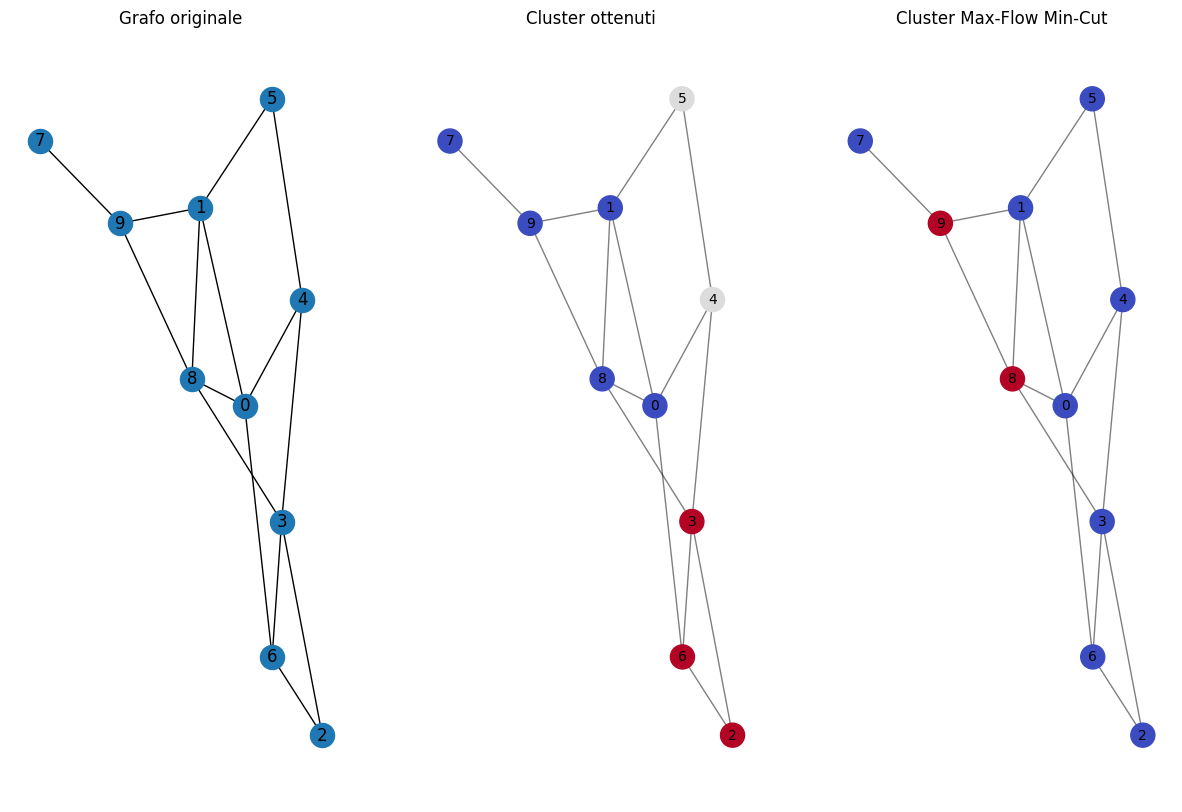

In [57]:
import networkx as nx
import matplotlib.pyplot as plt
import pulp

# Creazione del grafo casuale
G = nx.gnm_random_graph(n=10, m=15, seed=42)


# Definizione del problema di ottimizzazione
prob = pulp.LpProblem("Minimum_MultiCut", pulp.LpMinimize)

# Variabili binarie x_ij
x = pulp.LpVariable.dicts("x", G.edges(), lowBound=0, upBound=1, cat=pulp.LpBinary)

# Funzione obiettivo: minimizzare la somma dei valori delle variabili x_ij
prob += pulp.lpSum(x[edge] for edge in G.edges())

# Vincolo di connettività: ogni nodo i deve essere assegnato a un solo sottografo
for node in G.nodes():
    prob += pulp.lpSum(x[(i, j)] for i, j in G.edges() if i == node or j == node) == 1

# Se si utilizzano le variabili continue y_i per misurare l'associazione del nodo i al cluster principale,
# dovremmo aggiungere i vincoli di bilanciamento:
# y_i = 1 se il nodo i appartiene al cluster principale, y_i = 0 altrimenti

# Risoluzione del problema
#prob.solve()
prob.solve(pulp.PULP_CBC_CMD(msg=0))

# Stampa del risultato
print("Status:", pulp.LpStatus[prob.status])

# Stampa delle variabili binarie con valore 1 (i.e., archi del multi-cut)
print("=====================================================")
print("Archi del multi-cut:")
print("=====================================================")
for edge in G.edges():
    if pulp.value(x[edge]) == 1:
        print(edge)



# Per visualizzare i cluster
pos = nx.spring_layout(G)  # Layout per posizionare i nodi
plt.figure(figsize=(15, 10))  # Dimensione della figura

# Prima visualizzazione: Grafo originale con etichette dei nodi
plt.subplot(1, 3, 1)
plt.axis("off")
nx.draw_networkx(G, pos, with_labels=True)
plt.title("Grafo originale")

# Seconda visualizzazione: Cluster ottenuti da Louvain
plt.subplot(1, 3, 2)
plt.axis("off")
# Coloriamo i nodi in base all'etichetta del cluster
nx.draw_networkx_nodes(G, pos, node_size=300, cmap=plt.get_cmap("coolwarm"), node_color=list(partition.values()))
nx.draw_networkx_edges(G, pos, alpha=0.5)
# Aggiungi le label dei nodi originali (etichette dei nodi iniziali)
node_labels = {node: str(node) for node in G.nodes()}
nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=10, font_color='black')
plt.title("Cluster ottenuti")

# Terza visualizzazione: Cluster ottenuti da Max-Flow Min-Cut
plt.subplot(1, 3, 3)
plt.axis("off")
# Coloriamo i nodi in base alla partizione ottenuta
nx.draw_networkx_nodes(G, pos, node_size=300, cmap=plt.get_cmap("coolwarm"), node_color=list(color_map.values()))
nx.draw_networkx_edges(G, pos, alpha=0.5)
# Aggiungi le label dei nodi originali (etichette dei nodi iniziali)
node_labels = {node: str(node) for node in G.nodes()}
nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=10, font_color='black')
plt.title("Cluster Max-Flow Min-Cut")

plt.show()